# COVID-19 Daily Confirmed Cases Forecasting using ARIMA

# Import necessary Liberaries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('covid_wikipedia_tables.csv')

# Data sample
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,Date,West,Midwest,South,Northeast,Territories,Date,Confirmed,Deaths,Recovered,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AK,AZ,CA,CO,HI,ID,MT,NM,NV,OR,...,VI,New,Cml,New,Cml,New,Cml,Cml,NaN,NaN
2,Jan 21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Jan 21,1,1,NaN,NaN,NaN,NaN,1
3,Jan 24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Jan 24,1,2,NaN,NaN,NaN,NaN,2
4,Jan 25,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Jan 25,1,3,NaN,NaN,NaN,NaN,3


In [2]:
df.shape

(258, 64)

## Clean and organize the table

In [3]:
## df contains both tables, the first table contains cases
cases = df.copy()

## drop the first row filled with misplaced headers
cases.drop(0, axis=0, inplace=True)

## drop the extra date column
cases.drop('56', axis=1, inplace=True)

## set up the proper column names
col_names = ['Date']
col_names = col_names + list(cases.loc[1])
col_names = [x for x in col_names if str(x) != 'nan']

col_names[56] = 'Confirmed New'
col_names[57] = 'Confirmed Cml'
col_names[58] = 'Deaths New'
col_names[59] = 'Deaths Cml'
col_names[60] = 'Recovered New'
col_names[61] = 'Recovered Cml'
last_col = ['Active Cml']
col_names = col_names + last_col

cases.columns = col_names

## drop rows with extra column headers
rows_to_drop = [1,18,19,51,52,83,84,116,117,148,149,181,182,214,215,246,247,251,252,253,254,255,256,257]

for row in rows_to_drop:
    cases.drop(row, axis=0, inplace=True)

## fill nans with 0
cases.fillna(0, inplace=True)

## convert dates from string to datetime
import datetime as dt

cases['Date'] = [dt.datetime.strptime(d + ' 2020', '%b %d %Y') for d in cases['Date']]

cases.reset_index(drop=True, inplace=True)

cases.set_index('Date', inplace=True)

cases=cases.astype(float)

print(len(cases))

233


In [4]:
cases.head()

,AK,AZ,CA,CO,HI,ID,MT,NM,NV,OR,...,MP,PR,VI,Confirmed New,Confirmed Cml,Deaths New,Deaths Cml,Recovered New,Recovered Cml,Active Cml
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0
2020-01-25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,3.0
2020-01-26,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,5.0
2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,6.0


In [5]:
# data volume
cases.shape

(233, 62)

## Plot Daily Cases and 7-day rolling mean

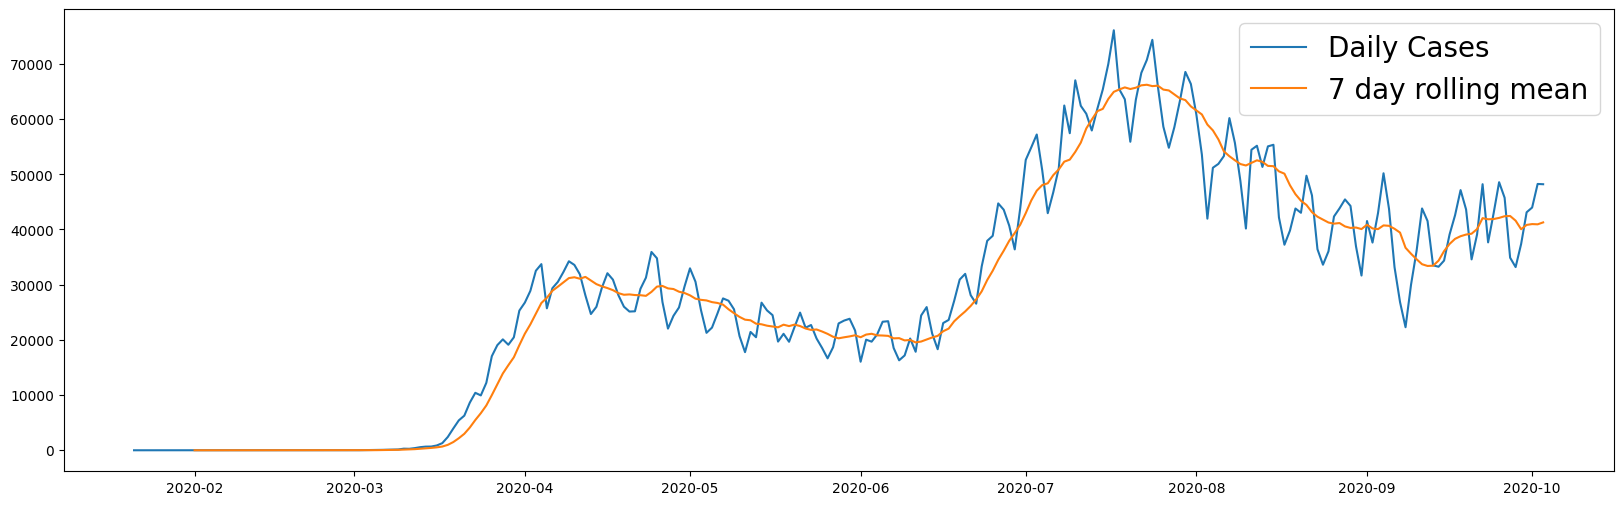

In [6]:
plt.figure(figsize=(20,6))
plt.plot(cases.index.values, cases['Confirmed New'], label = 'Daily Cases')
plt.plot(cases.index.values, cases['Confirmed New'].rolling(7).mean(), label = '7 day rolling mean')
plt.legend(prop={'size': 20})
plt.show()

## Plot Autocorrelation and Partial autocorrelation on a range of lag times

In [7]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

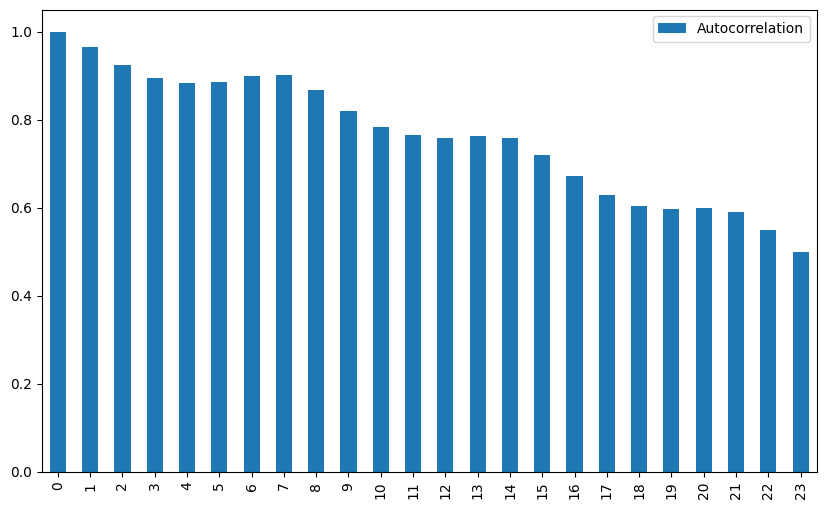

In [8]:
acf_1 = acf(cases['Confirmed New'])
acf_df = pd.DataFrame([acf_1]).T
acf_df.columns = ['Autocorrelation']
acf_df.plot(kind='bar', figsize=(10,6))
plt.show()
# acf_df

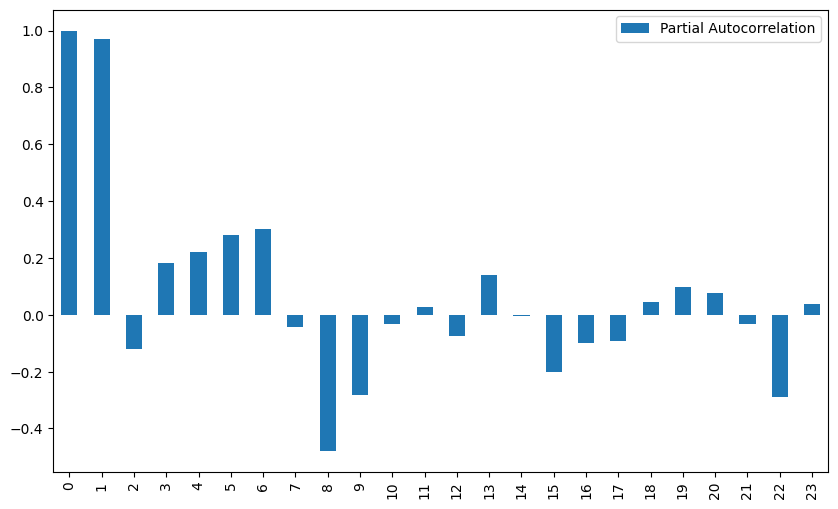

In [9]:
pacf_1 = pacf(cases['Confirmed New'])
pacf_df = pd.DataFrame([pacf_1]).T
pacf_df.columns = ['Partial Autocorrelation']
pacf_df.plot(kind='bar', figsize=(10,6))
plt.show()

## Hyperparameter fitting for ARIMA model

In [10]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [11]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    rmse = np.sqrt(mse)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [12]:
hyper_fitting = cases

p_values = [5, 6, 7, 8, 9, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(hyper_fitting['Confirmed New'].values, p_values, d_values, q_values)

ARIMA(5, 0, 0) RMSE=5596.708
ARIMA(5, 0, 1) RMSE=5448.591
ARIMA(5, 0, 2) RMSE=5464.175
ARIMA(5, 1, 0) RMSE=5166.242
ARIMA(5, 1, 1) RMSE=5186.269
ARIMA(5, 1, 2) RMSE=4721.620
ARIMA(5, 2, 0) RMSE=6641.659
ARIMA(5, 2, 1) RMSE=5104.956
ARIMA(5, 2, 2) RMSE=5052.745
ARIMA(6, 0, 0) RMSE=5156.144
ARIMA(6, 0, 1) RMSE=5199.402
ARIMA(6, 0, 2) RMSE=4827.782
ARIMA(6, 1, 0) RMSE=5288.576
ARIMA(6, 1, 1) RMSE=5052.102
ARIMA(6, 1, 2) RMSE=4603.701
ARIMA(6, 2, 0) RMSE=5048.262
ARIMA(6, 2, 1) RMSE=4621.118
ARIMA(6, 2, 2) RMSE=4641.250
ARIMA(7, 0, 0) RMSE=5279.061
ARIMA(7, 0, 1) RMSE=5028.242
ARIMA(7, 0, 2) RMSE=4768.780
ARIMA(7, 1, 0) RMSE=4747.516
ARIMA(7, 1, 1) RMSE=4522.360
ARIMA(7, 1, 2) RMSE=4535.637
ARIMA(7, 2, 0) RMSE=4649.133
ARIMA(7, 2, 1) RMSE=4629.101
ARIMA(7, 2, 2) RMSE=4654.921
ARIMA(8, 0, 0) RMSE=4743.893
ARIMA(8, 0, 1) RMSE=4500.867
ARIMA(8, 0, 2) RMSE=4461.648
ARIMA(8, 1, 0) RMSE=4508.922
ARIMA(8, 1, 1) RMSE=4498.188
ARIMA(8, 1, 2) RMSE=4572.921
ARIMA(8, 2, 0) RMSE=4631.294
ARIMA(8, 2, 1)

## Train/Test splits and Plots

In [13]:
X = cases['Confirmed New'].values
print(len(X))
# last 60 days for testing and rest for training
train_size = len(X)-60
train, test = X[0:train_size], X[train_size:]
train_time, test_time = cases.index[0:train_size], cases.index[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
# for t in range(len(test)):

model = ARIMA(history, order=(9,0,0))
model_fit = model.fit()
yhats = model_fit.forecast(steps=len(test))

233


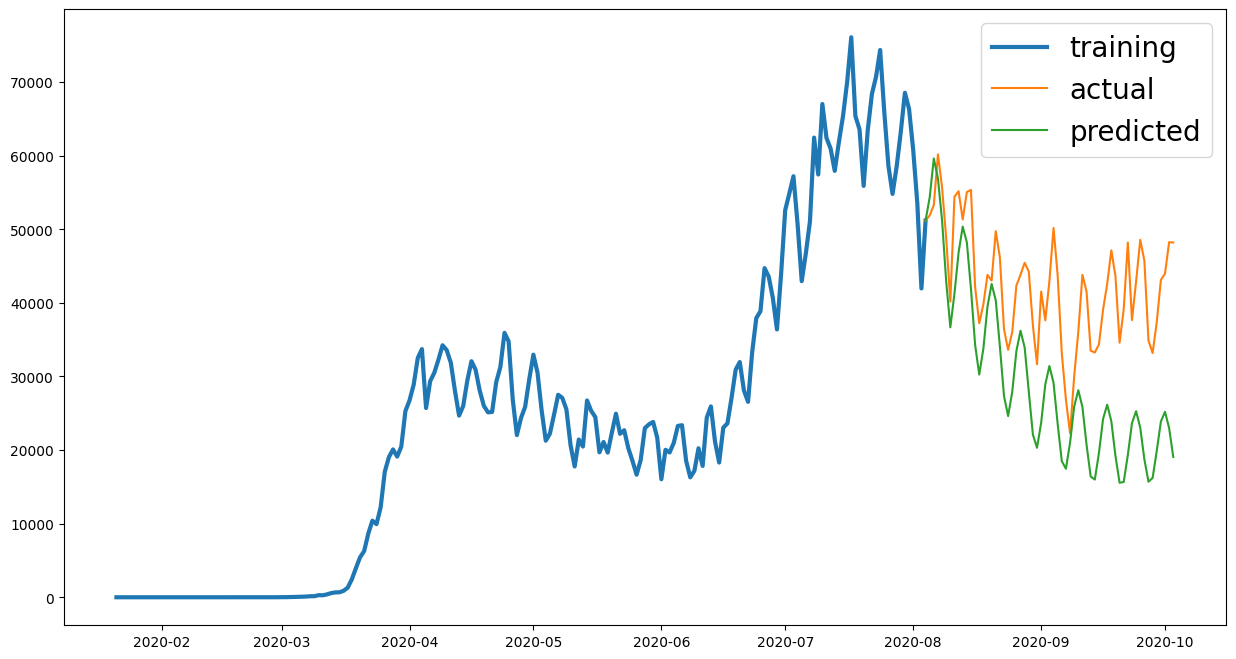

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,8))

plt.plot(train_time, train, label='training', linewidth=3)

plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(test,0,train[-1]), label='actual')
plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(yhats,0,train[-1]), label='predicted')
plt.legend(prop={'size': 20})

In [15]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def pred_and_plot(days):
    X = cases['Confirmed New'].values

    train_size = len(X)-days
    train, test = X[0:train_size], X[train_size:]
    train_time, test_time = cases.index[0:train_size], cases.index[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    # for t in range(len(test)):

    model = ARIMA(history, order=(9,0,0))
    model_fit = model.fit()
    yhats = model_fit.forecast(steps=len(test))

    print('Number of Days predicted: %s' % days)

    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(15,8))

    plt.plot(train_time, train, label='training', linewidth=3)

    plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(test,0,train[-1]), label='actual')
    plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(yhats,0,train[-1]), label='predicted')


    plt.legend(prop={'size': 20})

    rmse = np.sqrt(mean_squared_error(test, yhats))
    print('RMSE=%.3f' % rmse)

    plt.show()

    return rmse

Number of Days predicted: 5
RMSE=6231.305


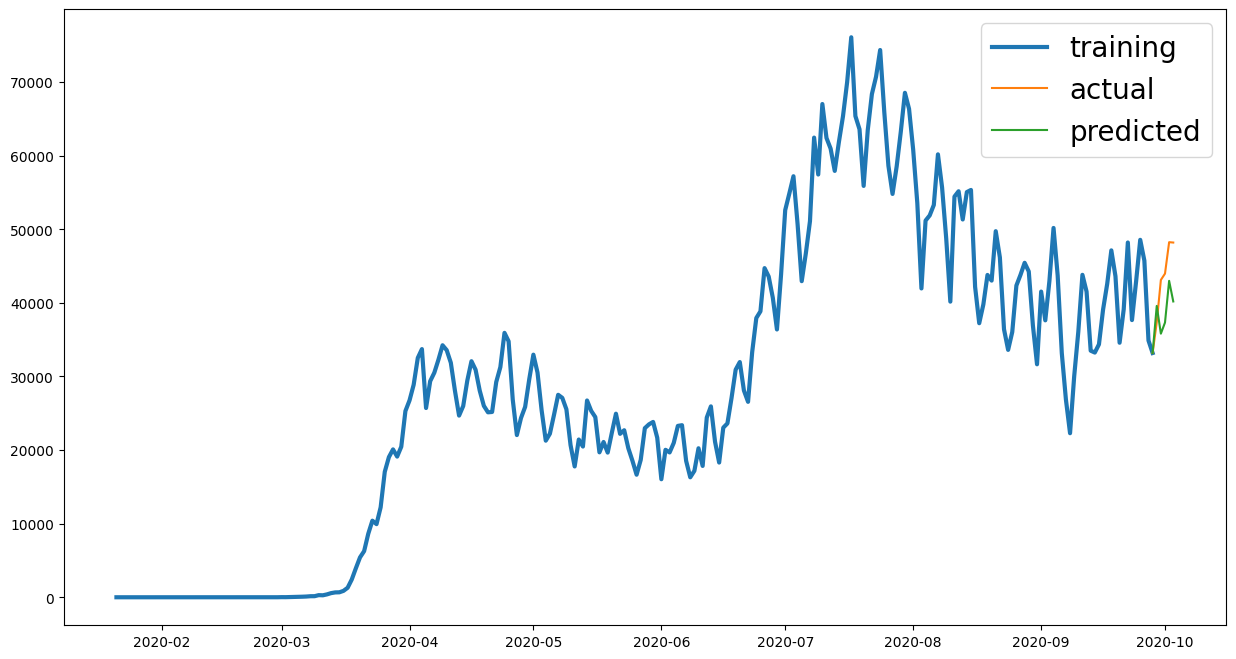

Number of Days predicted: 10
RMSE=4298.347


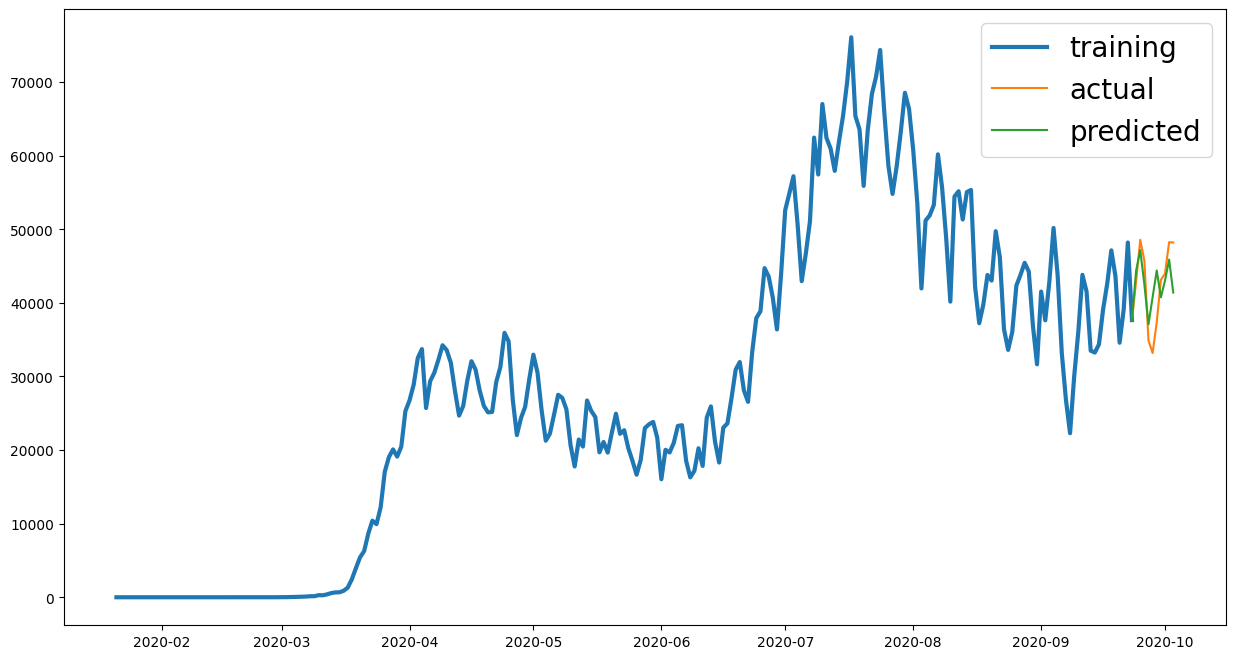

Number of Days predicted: 20
RMSE=10490.762


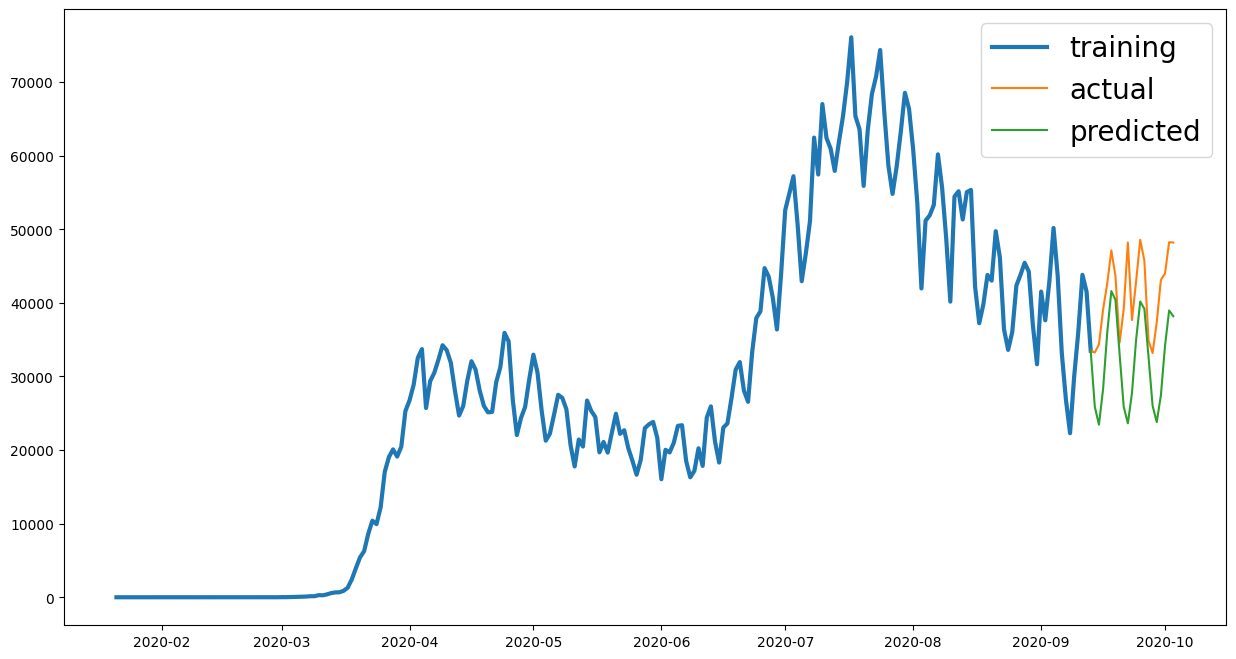

Number of Days predicted: 30
RMSE=7539.485


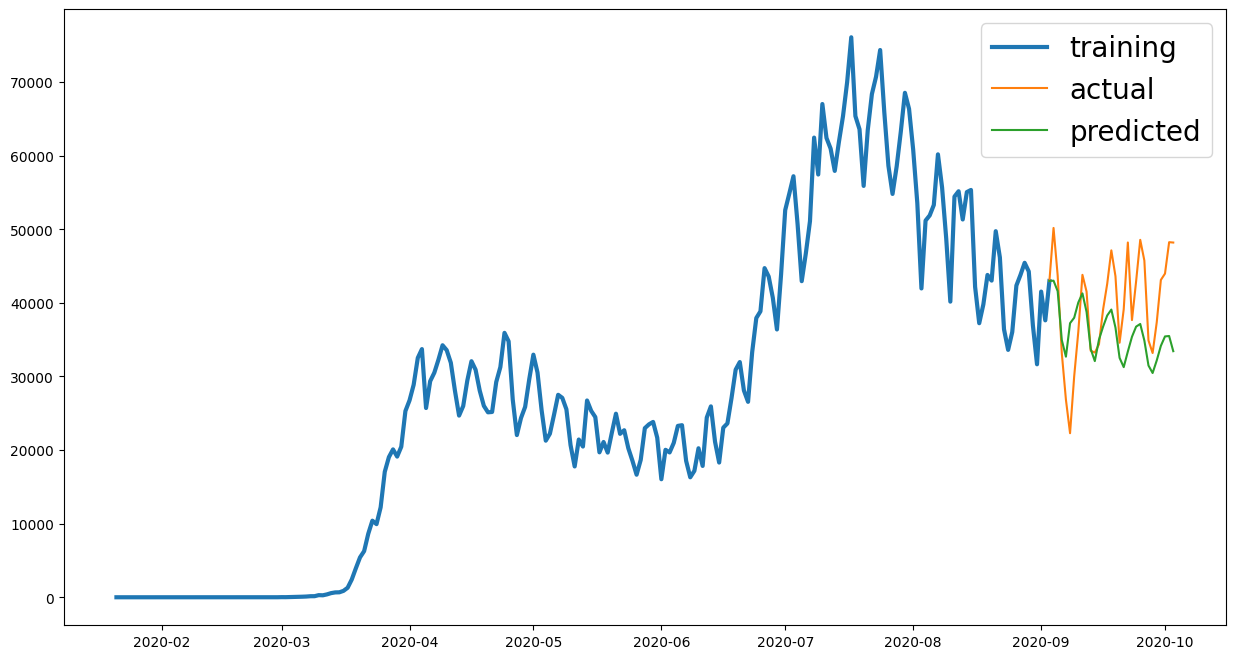

Number of Days predicted: 60
RMSE=15201.814


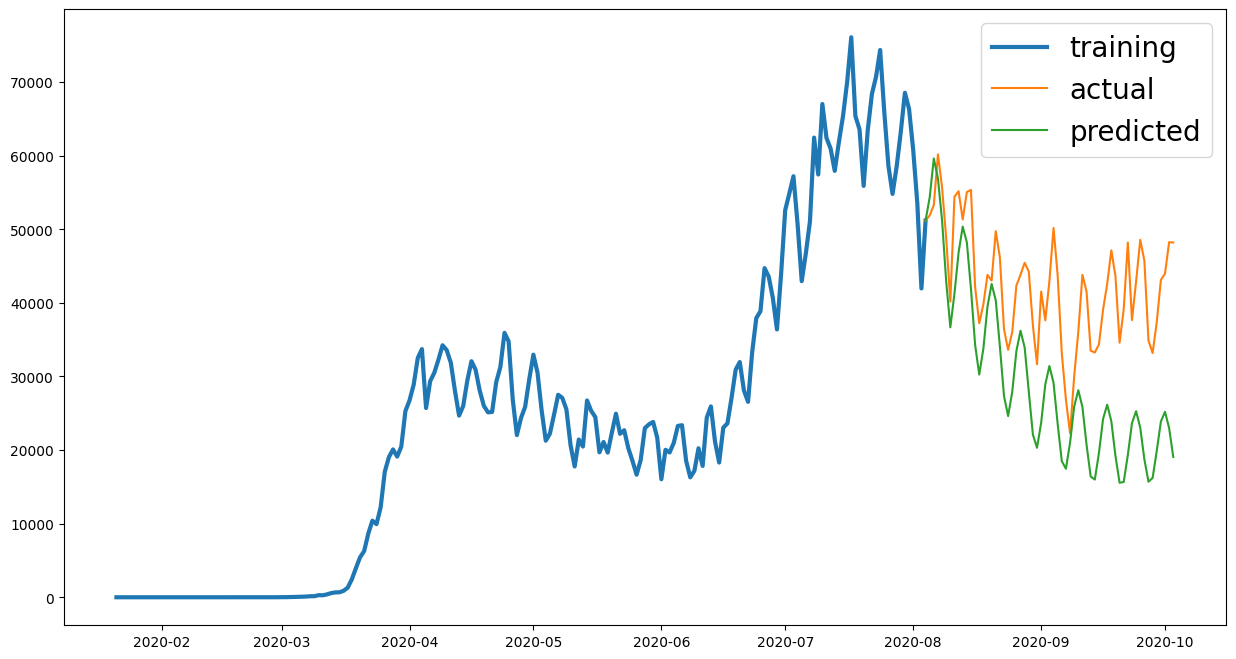

Number of Days predicted: 100
RMSE=25574.826


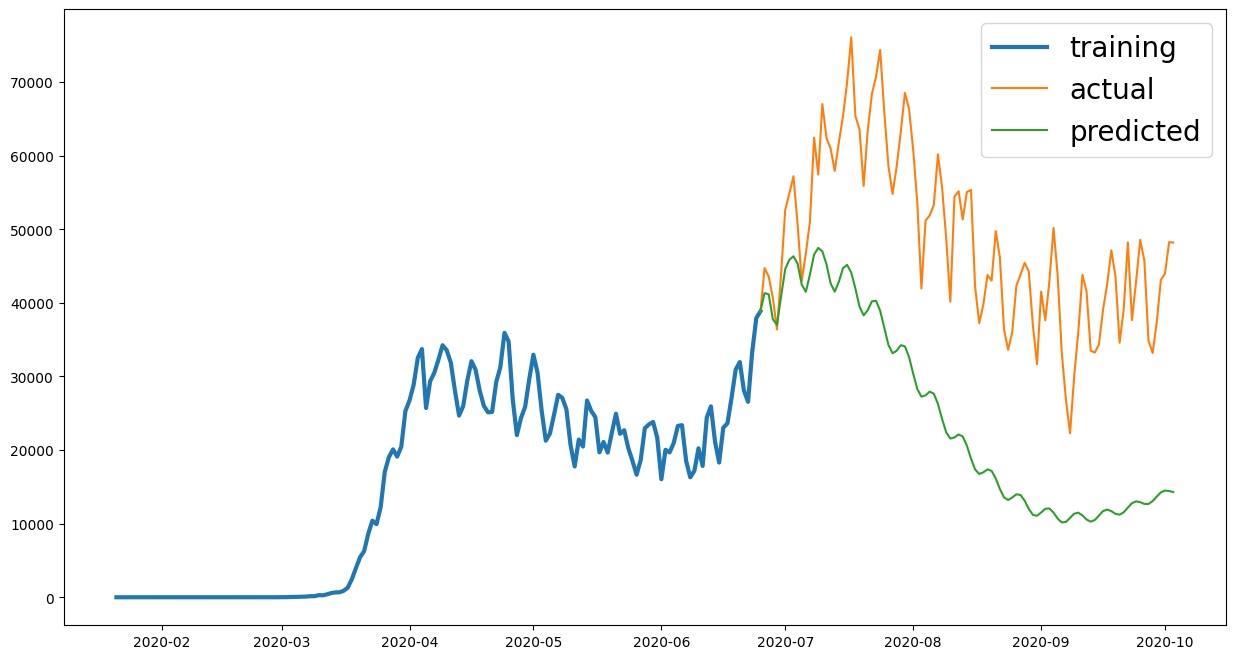

In [16]:
num_days_predicted = [5,10,20,30,60,100]
rmse_plain = []

for days in num_days_predicted:
    rmse = pred_and_plot(days)
    rmse_plain.append(rmse)


## Including Exogenous Variable

#### We have done prediction using the endogenous variable, but many people believe there are important exogenous variables. Many protests erupted across the nation in May, followed by a sharp increase in new Covid case. Let's see if the inclusion of protest data as an exogenous variable can increase the accuracy of our fit.

#### Data is take from https://acleddata.com/special-projects/us-crisis-monitor/

In [18]:

protest_data = pd.read_excel('/content/USA_2020_Sep26.xlsx')
protest_data.head()

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,ADMIN2,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES
0,840,USA4524,4524,2020-05-24,2020,1,Protests,Peaceful protest,Protesters (United States),NaN,...,Baltimore City,NaN,Baltimore,39.290,-76.612,1,Fox45 (Baltimore),Subnational,"On 24 May 2020, a caravan of people staged a m...",0
1,840,USA4525,4525,2020-05-24,2020,1,Protests,Peaceful protest,Protesters (United States),NaN,...,Williamson,NaN,Marion,37.731,-88.933,1,Southern Illinoisan,Subnational,"On 24 May 2020, nearly 50 people held a ""Patri...",0
2,840,USA4526,4526,2020-05-24,2020,1,Protests,Peaceful protest,Protesters (United States),NaN,...,Mahoning,NaN,Youngstown,41.100,-80.650,1,WKBN,Subnational,"On 24 May 2020, an unreported number of people...",0
3,840,USA4527,4527,2020-05-24,2020,1,Protests,Peaceful protest,Protesters (United States),Teachers (United States); Latinx Group (United...,...,Middlesex,NaN,New Brunswick,40.486,-74.452,1,My Central Jersey,Subnational,"On 24 May 2020, more than a dozen vehicles, or...",0
4,840,USA4528,4528,2020-05-24,2020,1,Protests,Peaceful protest,Protesters (United States),NaN,...,Essex,NaN,Keene,44.256,-73.792,1,Post-Star,Subnational,"On 24 May 2020, a few people staged a protest ...",0


In [19]:
set(protest_data['EVENT_TYPE'])

{'Battles',
 'Protests',
 'Riots',
 'Strategic developments',
 'Violence against civilians'}

In [20]:
options = ['Protests', 'Riots']

protest_data = protest_data[protest_data['EVENT_TYPE'].isin(options)]
len(protest_data)

13162

In [21]:
protest_num = protest_data.groupby('EVENT_DATE')['ISO'].count().to_frame()

protest_num.columns = ['protests']

df_a = pd.DataFrame(data=np.zeros(100), index=cases.index[:100], columns=['protests'])
df_b = pd.DataFrame(data=np.zeros(7), index=cases.index[-7:], columns=['protests'])

protest_num = pd.concat([df_a, protest_num, df_b])

## Plot of number of protests per day

#### Counting starts 5/24 and ends 9/26

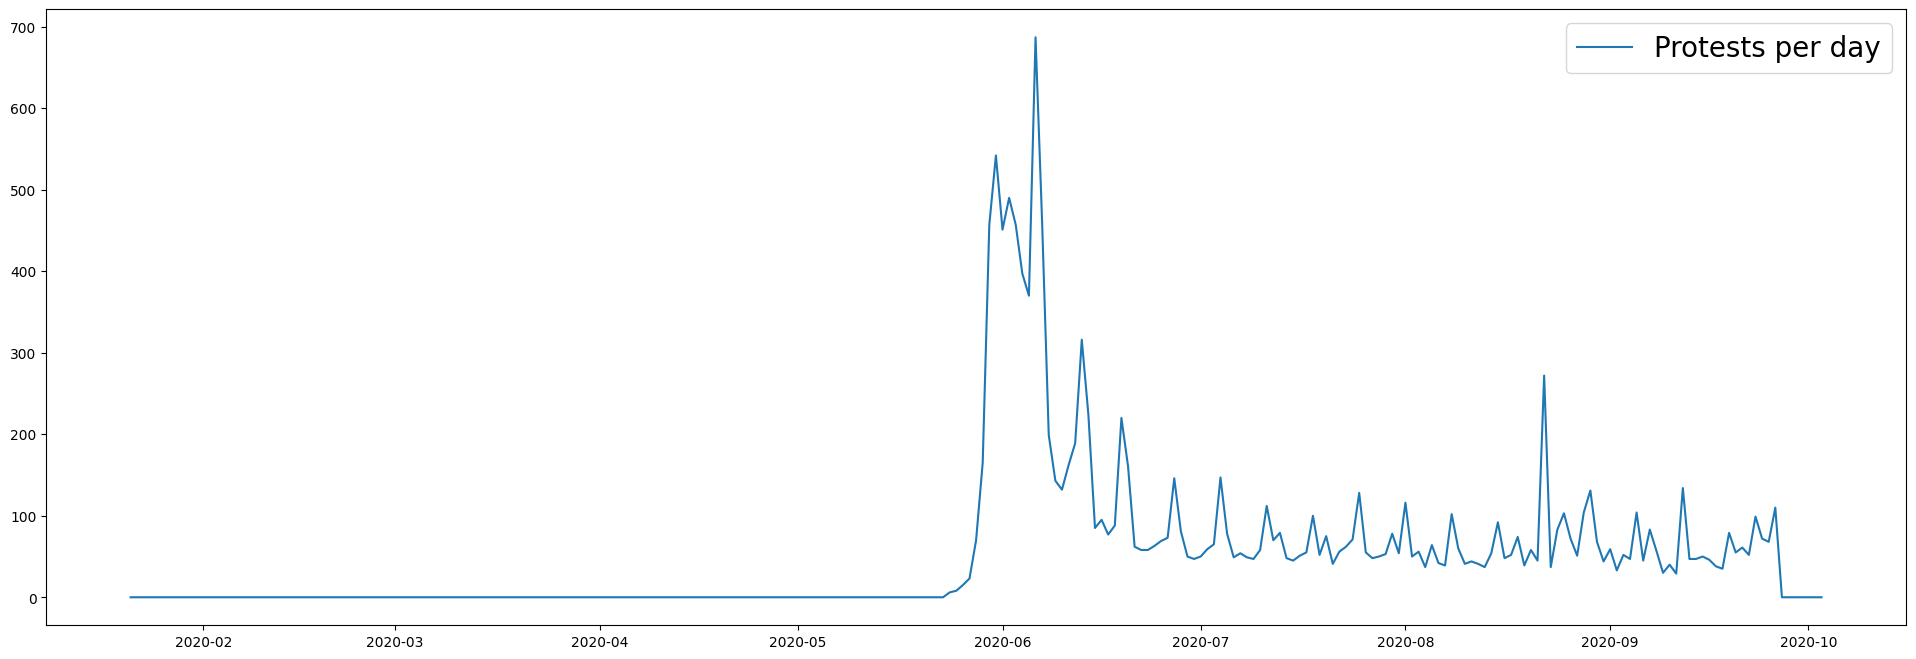

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(24,8))

plt.plot(protest_num.index.values, protest_num['protests'], label = 'Protests per day')
plt.legend(prop={'size': 20})
plt.show()

In [24]:
def evaluate_arima_model_exog(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    train_ex, test_ex = protest_num['protests'][0:train_size], protest_num['protests'][train_size:]
    history = [x for x in train]
    history_ex = [x for x in train_ex]
    # make predictions
    predictions = list()
    for t in range(len(test)):

        model = ARIMA(history, order=arima_order, exog=history_ex)
        model_fit = model.fit()
        yhat = model_fit.forecast(exog=[test_ex[t]])[0]
        predictions.append(yhat)
        history.append(test[t])
        history_ex.append(test_ex[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [25]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models_exog(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model_exog(dataset, order)
                    rmse = np.sqrt(mse)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [26]:
p_values = [5, 6, 7, 8, 9, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models_exog(cases['Confirmed New'].values, p_values, d_values, q_values)

ARIMA(5, 0, 0) RMSE=5603.336
ARIMA(5, 0, 1) RMSE=5596.650
ARIMA(5, 0, 2) RMSE=7842.781
ARIMA(5, 1, 0) RMSE=5234.781
ARIMA(5, 1, 1) RMSE=5259.332
ARIMA(5, 2, 0) RMSE=6728.204
ARIMA(5, 2, 1) RMSE=5205.243
ARIMA(5, 2, 2) RMSE=5022.589
ARIMA(6, 1, 0) RMSE=5340.848
ARIMA(6, 1, 1) RMSE=5073.555
ARIMA(6, 1, 2) RMSE=4638.453
ARIMA(6, 2, 0) RMSE=5048.874
ARIMA(6, 2, 1) RMSE=4639.811
ARIMA(6, 2, 2) RMSE=4667.298
ARIMA(7, 0, 1) RMSE=5132.064
ARIMA(7, 0, 2) RMSE=5159.483
ARIMA(7, 1, 0) RMSE=4747.555
ARIMA(7, 1, 1) RMSE=4535.568
ARIMA(7, 1, 2) RMSE=4594.776
ARIMA(7, 2, 0) RMSE=4677.502
ARIMA(7, 2, 1) RMSE=4659.118
ARIMA(7, 2, 2) RMSE=4695.660
ARIMA(8, 0, 0) RMSE=4755.070
ARIMA(8, 0, 1) RMSE=4570.419
ARIMA(8, 0, 2) RMSE=4677.726
ARIMA(8, 1, 0) RMSE=4534.869
ARIMA(8, 1, 1) RMSE=4524.702
ARIMA(8, 1, 2) RMSE=4649.489
ARIMA(8, 2, 0) RMSE=4660.938
ARIMA(8, 2, 1) RMSE=4549.914
ARIMA(8, 2, 2) RMSE=4710.883
ARIMA(9, 0, 1) RMSE=4612.252
ARIMA(9, 0, 2) RMSE=4656.839
ARIMA(9, 1, 0) RMSE=4543.535
ARIMA(9, 1, 1)

In [27]:
def pred_and_plot_exog(days):
    X = cases['Confirmed New'].values

    train_size = len(X)-days
    train, test = X[0:train_size], X[train_size:]
    train_time, test_time = cases.index[0:train_size], cases.index[train_size:]
    train_ex, test_ex = protest_num['protests'][0:train_size], protest_num['protests'][train_size:]

    history = [x for x in train]
    history_ex = [x for x in train_ex]
    # make predictions
    predictions = list()
    # for t in range(len(test)):

    model = ARIMA(history, order=(8,1,1), exog=history_ex)
    model_fit = model.fit()
    yhats = model_fit.forecast(steps=len(test), exog=test_ex)

    print('Number of Days predicted: %s' % days)

    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    %matplotlib inline
    fig = plt.figure(figsize=(15,8))
    spec = gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[1, 3])
    plt.subplots_adjust(hspace=0.0)

    ax1 = fig.add_subplot(spec[0])
    plt.plot(protest_num.index.values, protest_num['protests'], color='black', label = 'Protests per day')
    plt.legend(prop={'size': 20})
    plt.setp(ax1.get_xticklabels(), visible=False)

    # share x only
    ax2 = fig.add_subplot(spec[1])
    plt.plot(train_time, train, label='training', linewidth=3)

    plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(test,0,train[-1]), label='actual')
    plt.plot(np.insert(test_time,0,train_time[-1]), np.insert(yhats,0,train[-1]), label='predicted')

    plt.legend(prop={'size': 20})

    rmse = np.sqrt(mean_squared_error(test, yhats))
    print('RMSE=%.3f' % rmse)

    plt.show()

    return rmse

## A note before looking at the following plots:

#### We are predicting covid cases using the *actual* protest numbers. If we were being more careful we would use past protest numbers to forecast the protest numbers used to forecast the covid case numbers. As we can see from the protest number plot, from July onward, the protest numbers are fairly stationary, so this should be acceptable for our purposes.

Number of Days predicted: 5
RMSE=5719.305


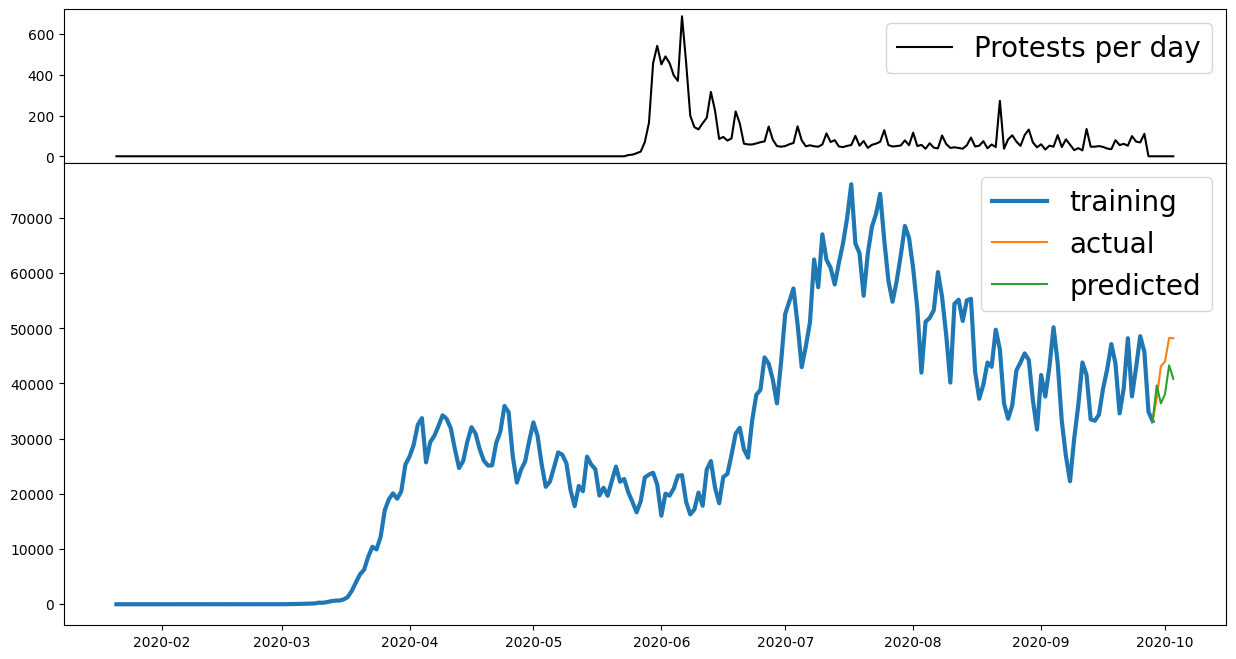

Number of Days predicted: 10
RMSE=4265.789


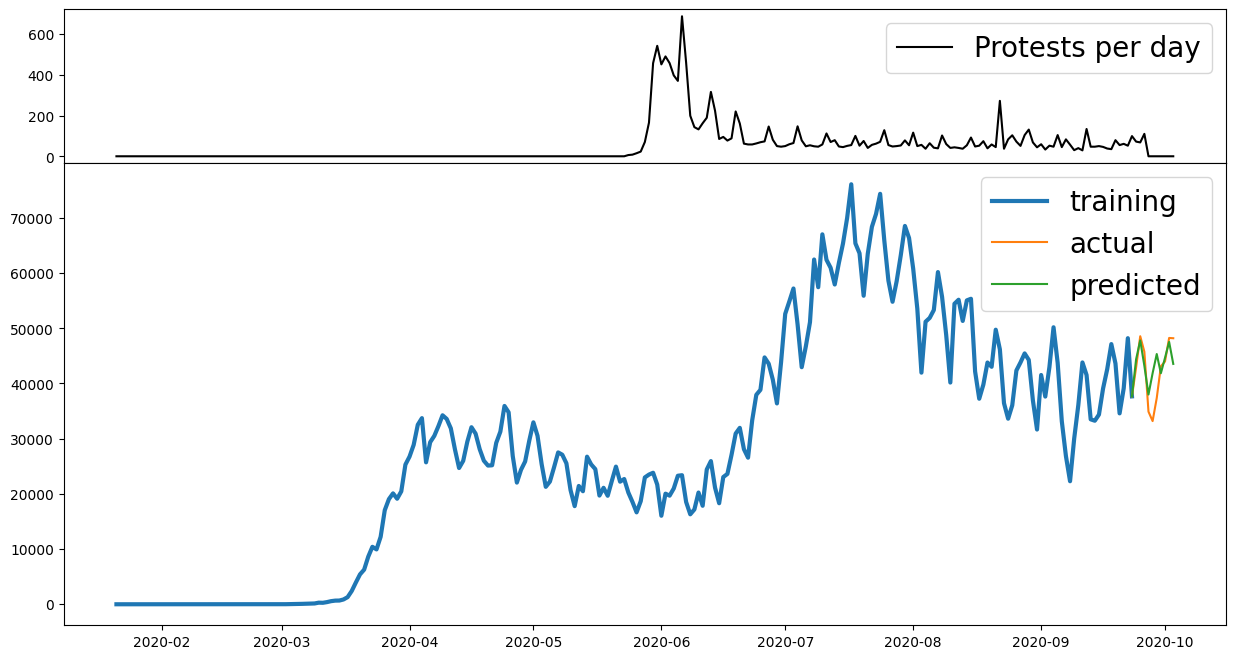

Number of Days predicted: 20
RMSE=11152.844


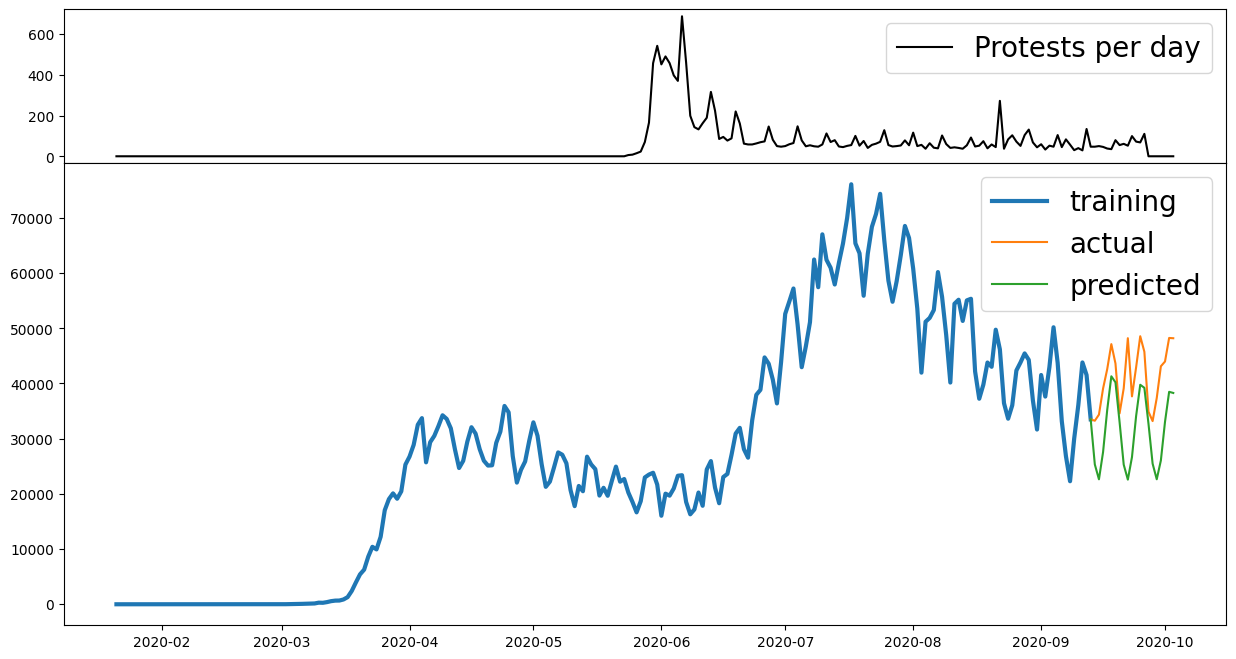

Number of Days predicted: 30
RMSE=5872.394


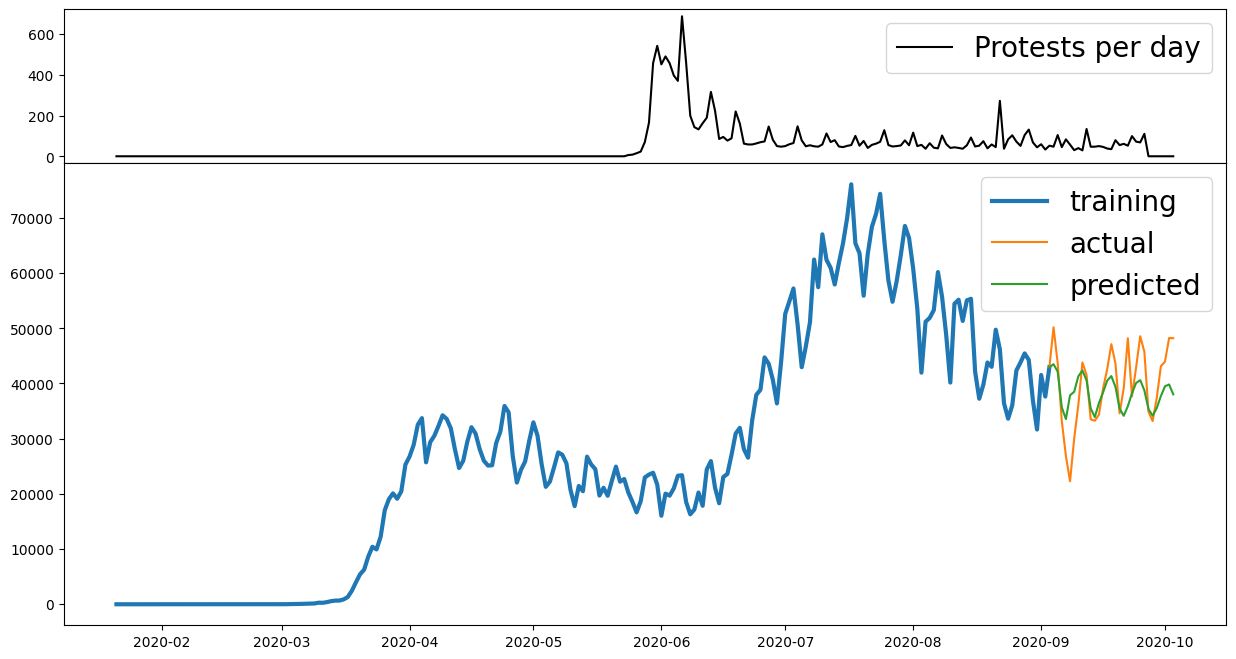

Number of Days predicted: 60
RMSE=6429.738


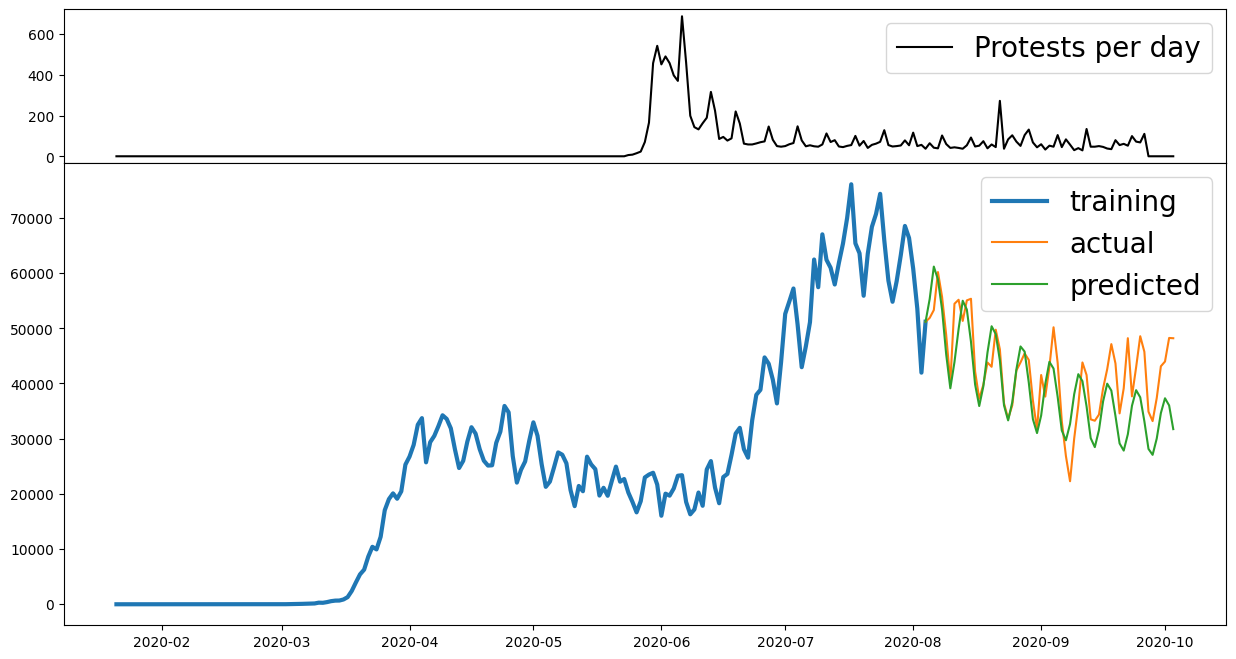

Number of Days predicted: 100
RMSE=28379.340


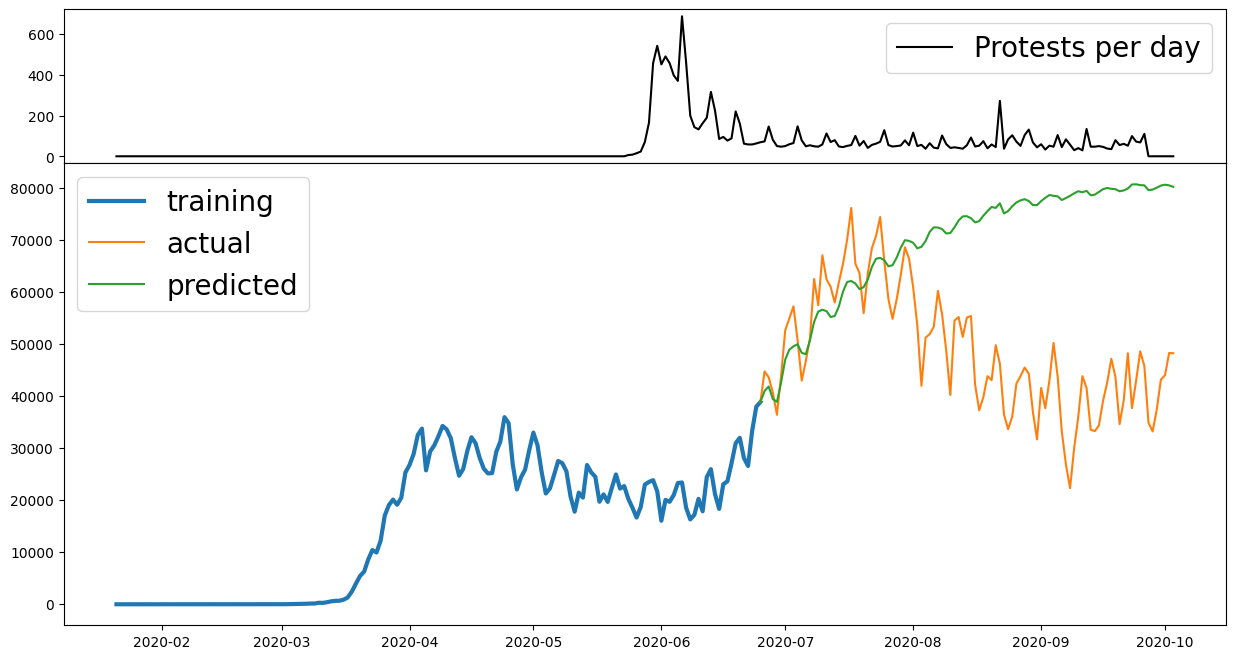

In [28]:
num_days_predicted = [5,10,20,30,60,100]
rmse_exog = []

for days in num_days_predicted:
    rmse = pred_and_plot_exog(days)
    rmse_exog.append(rmse)


## Comparison of Forecasting for "Plain" model vs model with Exogenous Variable

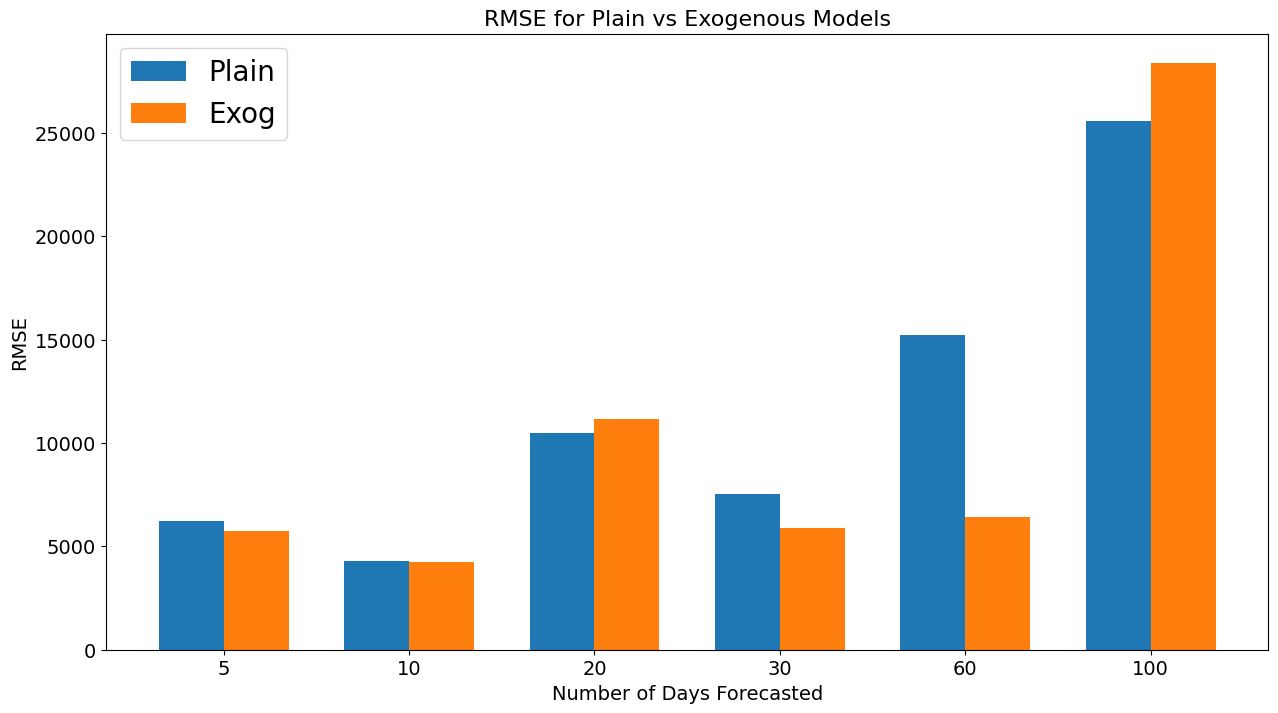

In [29]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
fig = plt.figure(figsize=(15,8))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

N = 6
ind = np.arange(N)
width = 0.35
plt.bar(ind, rmse_plain, width, label='Plain')
plt.bar(ind + width, rmse_exog, width,
    label='Exog')

plt.ylabel('RMSE', fontsize=14)
plt.xlabel('Number of Days Forecasted', fontsize=14)
plt.title('RMSE for Plain vs Exogenous Models', fontsize=16)

plt.xticks(ind + width / 2, ('5', '10', '20', '30', '60', '100'))
plt.legend(loc='best', prop={'size': 20})

plt.show()

#### We can see from this plot that the model with an included exogenous variable of number of protests improved the fit for 5-60 days. Given the number of days recorded and the rate of change, it's probably not appropriate to be forecasting out 100 days, so we won't worry too much about those computed error terms.